# Question 2


In [1]:
from astroquery.gaia import Gaia
from astropy.table import Table
import matplotlib.pyplot as plt
import os
import numpy as np


In [2]:

# Cone search for Gaia stars around Ruprecht 147 brighter than G = 14, crossmatched with 2MASS
query = """
    SELECT
        g.source_id, g.ra, g.dec,
        g.phot_g_mean_mag, g.bp_rp, g.parallax, 
        t.ph_qual, t.j_m, t.h_m, t.ks_m
    FROM gaiadr3.gaia_source AS g
    JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS x
        ON g.source_id = x.source_id
    JOIN gaiadr1.tmass_original_valid AS t
        ON t.designation  = x.original_ext_source_id
    WHERE 1 = CONTAINS(
        POINT('ICRS', g.ra, g.dec),
        CIRCLE('ICRS', 289.074, -16.323, 1.0))
    AND g.phot_g_mean_mag < 14
"""

job = Gaia.launch_job_async(query)
cluster_results = job.get_results()

for col in cluster_results.colnames[1:-4]:
    cluster_results[col].format = '%.4f'  
cluster_results.write("ruprecht147_cluster.csv", overwrite=True)

cluster_data = Table.read('ruprecht147_cluster.csv')
print(cluster_data)
print(f"Total Gaia stars (G<14) in 1° cone crossmatched with 2MASS catalogue: {len(cluster_results)}")



INFO: Query finished. [astroquery.utils.tap.core]
     source_id         ra      dec    ...        h_m                ks_m       
------------------- -------- -------- ... ------------------ ------------------
4088892600474423808 288.2259 -15.7442 ...   9.40999984741211  9.218000411987305
4088893154546972672 288.2713 -15.7096 ...  9.187999725341797  9.005000114440918
4088893188906716032 288.2544  -15.714 ...  9.732999801635742  9.503000259399414
4087815667506086656 288.5123 -16.8744 ...  9.710000038146973  9.491999626159668
4087815697559746304  288.521 -16.8749 ...  7.314000129699707 7.0320000648498535
4087815697560348032 288.5318 -16.8694 ... 12.329000473022461 12.217000007629395
4088026150958748032  288.128 -16.6211 ... 11.826000213623047 11.777999877929688
4087815770585314176 288.4848 -16.8846 ... 11.029999732971191 10.930000305175781
4087815869358437632 288.5019 -16.8666 ...  9.527000427246094  9.371999740600586
4087816109876607488 288.4061 -16.8871 ... 10.934000015258789 10.850000

In [3]:
# Stars with bad 2MASS photometry (ph_qual not 'AAA')
bad_2mass = cluster_data[cluster_data['ph_qual'] != 'AAA']

# Stars with non-positive parallax
bad_parallax = cluster_data[cluster_data['parallax'] <= 0]

print(f"Stars with bad 2MASS photometry: {len(bad_2mass)}")
print(f"Stars with non-positive parallax: {len(bad_parallax)}")

good_data = cluster_data[
    (cluster_data['ph_qual'] == 'AAA') &
    (cluster_data['parallax'] > 0)
]

print(f"Stars remaining after quality cuts: {len(good_data)}")
good_data.write("ruprecht147_quality_cluster.csv", overwrite=True)


Stars with bad 2MASS photometry: 79
Stars with non-positive parallax: 23
Stars remaining after quality cuts: 3535


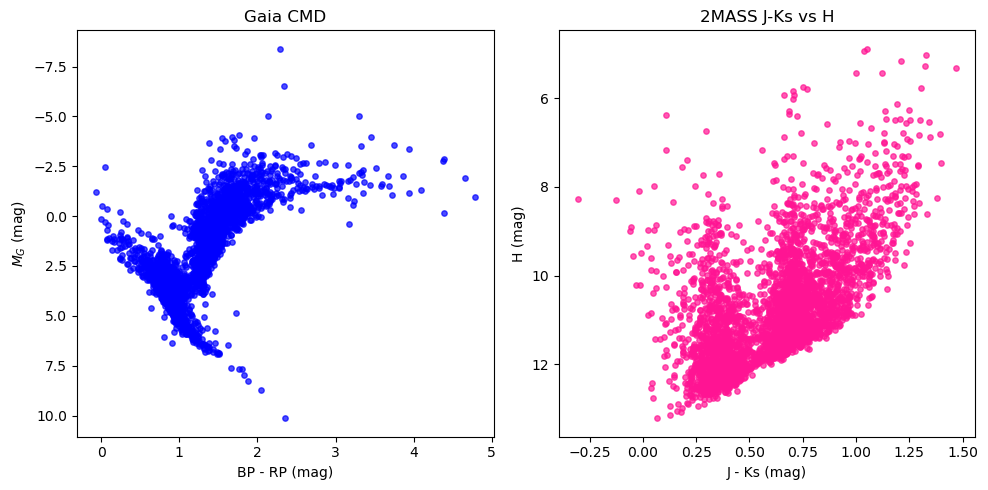

In [4]:
# Compute absolute G magnitude: M_G = G - 5 * log10(d/10)
# parallax in mas -> distance in pc = 1000 / parallax
distance_pc = 1000 / good_data['parallax']
abs_G = good_data['phot_g_mean_mag'] - 5 * np.log10(distance_pc / 10)

# Compute color indices
bp_rp = good_data['bp_rp']
j_k = good_data['j_m'] - good_data['ks_m']
h_mag = good_data['h_m']

# Create figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Panel (a): Gaia CMD
ax[0].scatter(bp_rp, abs_G, s=15, color='blue', alpha=0.7)
ax[0].invert_yaxis()  # brighter stars on top
ax[0].set_xlabel('BP - RP (mag)')
ax[0].set_ylabel(f'$M_G$ (mag)')
ax[0].set_title('Gaia CMD')

# Panel (b): 2MASS diagram
ax[1].scatter(j_k, h_mag, s=15, color='deeppink', alpha=0.7)
ax[1].invert_yaxis()
ax[1].set_xlabel('J - Ks (mag)')
ax[1].set_ylabel('H (mag)')
ax[1].set_title('2MASS J-Ks vs H')

plt.tight_layout()
plt.savefig('figures/cmds_R147.png', dpi=200)
plt.show()

The 2dF instrument has 392 science fibres each able to simultaneously take spectra, but since we have 3535 stars, we would need 9 pointings to observe all the stars.

Source: https://aat.anu.edu.au/files/2dF-AAOmega-obs-manual_3.pdf